# Hands-on session: Analysis of Higgs data

In [1]:
%reload_ext custom_magics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from custom_functions import *

In [3]:
num_workers=5
spark=%sc $num_workers

from pyspark.sql import SparkSession
spark_session = SparkSession(spark)

#check if spark is there
spark

Exception in thread Thread-3:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.9/site-packages/sparkmonitor/kernelextension.py", line 126, in run
    self.onrecv(msg)
  File "/opt/conda/lib/python3.9/site-packages/sparkmonitor/kernelextension.py", line 143, in onrecv
    sendToFrontEnd({
  File "/opt/conda/lib/python3.9/site-packages/sparkmonitor/kernelextension.py", line 223, in sendToFrontEnd
    monitor.send(msg)
  File "/opt/conda/lib/python3.9/site-packages/sparkmonitor/kernelextension.py", line 57, in send
    self.comm.send(msg)
AttributeError: 'ScalaMonitor' object has no attribute 'comm'


<SparkContext master=k8s://https://192.168.2.39:6443 appName=jupyter-annalisagilioli>

## Prepare the input data

In [4]:
inputFile = 'file:///home/jovyan/Higgs100k.parquet'
#inputFile = 'file:///home/jovyan/Higgs1M.parquet'
#inputFile = 'file:///home/jovyan/Higgs10M.parquet'

%time df = spark_session.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)

total_events = df.count()
print('There are '+str(total_events)+' events')

CPU times: user 6.09 ms, sys: 1.1 ms, total: 7.19 ms
Wall time: 4.75 s
There are 99999 events


In [5]:
total_events = df.count()

print('There are '+str(total_events)+' events')

There are 99999 events


## Feature engineering

### QUESTION 1: 

- Is the dataset unbalanced? 
- Do we need undersampling? 
- Do we need special preprocessing?

## Is the dataset unbalanced? 

In [6]:
#filtered_df = df.filter(df['label'] == 0)
filtered_df = df.filter(df['label'] == 1)

# Count
count_value = filtered_df.count()
print(f"Number of row with 'label' equal to 1: {count_value}")

Number of row with 'label' equal to 1: 52833


The dataset is balanced:
- number of rows with label=0: 47166 (47%)
- number of rows with label=0: 52833 (53%)


# Do we need undersampling?

We can consider a sub-sample to speed up the execution of the code. In fact, we have a big dataset (the total number of rows is 99999).

# Do we need special preprocessing?
No special pre-processing of the dataset is necessary since it is extensive and balanced.

### QUESTION 2: 

- Split the dataset into 5 roughly equal parts with random events

In [7]:
splits = df.randomSplit([0.2, 0.2, 0.2, 0.2, 0.2], seed=0)

for i, split in enumerate(splits):
    count = split.count()
    print(f"Subgroup {i+1}: {count} righe")



Subgroup 1: 20115 righe
Subgroup 2: 19951 righe
Subgroup 3: 19849 righe
Subgroup 4: 19993 righe
Subgroup 5: 20091 righe


### QUESTION 3: 
- split the dataset for training and test

In [8]:
#split the dataset for training and test
train, test = df.randomSplit([0.8,0.2])

print('Events for training {}'.format(train.count()))
print('Events for validation {}'.format(test.count()))

Events for training 80034
Events for validation 19965


### QUESTION 4:

- Create the input feature vector for MLLib
- Documentation on how to do data preprocessing in Spark: https://spark.apache.org/docs/latest/ml-features.html

In [9]:
# create input feature vector
feature = train.columns
feature.remove('label')

from pyspark.ml.feature import VectorAssembler

#VectorAssembler is a transformer that combines a given list of columns into a single vector column
assembler = VectorAssembler(inputCols=feature, outputCol='features')
train = assembler.transform(train)
test = assembler.transform(test)

## ML with pyspark

- Try to solve the signal vs background classification problem using a **new model of your choice** (obviously, not GBT or MCP)
- Documentation at: https://spark.apache.org/docs/3.2.1/ml-classification-regression.html

In [10]:
from pyspark.ml.classification import *

Fit the model on the **training dataset**: (dataframe train)

In [11]:
model = LinearSVC(maxIter=10, regParam=0.1)

# Fit the model
LSVC_model = model.fit(train)

# Print the coefficients and intercept for linear SVC
print("Coefficients: " + str(LSVC_model.coefficients))
print("Intercept: " + str(LSVC_model.intercept))

Coefficients: [-0.2936290910247132,-0.005678667496442856,-0.0,-0.449422567365776,-0.0,0.44719866078003945,-0.011603852280607596,0.002728275791994324,0.06200625764552445,0.09008049484231732,0.01000378319596735,0.0031208500829555974,-0.06177901753189543,0.06766670379240756,0.004852076670233098,0.01737837178744221,-0.053938521502710675,0.14556816112447582,-0.005780733869230981,0.007844528553966295,-0.024312754644315593,-0.012526524187798715,0.4629067987105466,0.605278668185751,0.3049244558357297,-0.8373959153812922,0.14104484761627437,-1.239894853379064]
Intercept: 0.9230353161488264


### QUESTION 5: 

- Compute the accuracy/AUC/relevant metrics on the test dataset

In [12]:
# compute AUC on the test set
result = LSVC_model.transform(test)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")
print("Test set AUC = " + str(evaluator.evaluate(result)))

Test set AUC = 0.6497308049380861


In [13]:
#print metrics
printMetrics(evaluator, result)

AUC: 0.650
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 9496|
|  0.0|       1.0| 6585|
|  1.0|       0.0| 1161|
|  0.0|       0.0| 2723|
+-----+----------+-----+

n precision: 0.591
n recall: 0.891
n accuracy: 0.612
n F1 score: 0.710


### QUESTION 6: 

- Check that you are neither underfitting nor overfitting

In [14]:
result = LSVC_model.transform(test)
print("Test set AUC = " + str(evaluator.evaluate(result)))
result_train = LSVC_model.transform(train)
print("Training set AUC = " + str(evaluator.evaluate(result_train)))

#-------------------------------------------------------------------------

test_accuracy = result.filter(result['prediction'] == result['label']).count() / float(test.count())
train_accuracy = result_train.filter(result_train['prediction'] == result_train['label']).count() / float(train.count())

print("Test set Accuracy = " + str(test_accuracy))
print("Training set Accuracy = " + str(train_accuracy))



Test set AUC = 0.6497456594641386
Training set AUC = 0.6564051416383168
Test set Accuracy = 0.6120210368144252
Training set Accuracy = 0.611002823799885


The AUC and Accuracy calculated on the training set and the test set are similar, so we should not be overfitting or underfitting.

In [15]:
# When you're done, stop spark
spark.stop()

### Final results

Pick any two models (can be any from pyspark MLLib, Keras + BigDL sequential) and  (you can use results from previous days):
- Compare them in terms of absolute performances. Discuss accuracy, ROC, AUC, feature importance, feature distributions. Which of these metrics do you deem more critical?
- Compare how they scale in terms of performances and training time when you change the number of executors (from 1 to 5)
- Discuss the results.  
- You can also collect results in external documents (google documents, pdf, whatever) and link them here

In [16]:
num_workers=5
spark=%sc $num_workers

from pyspark.sql import SparkSession
spark_session = SparkSession(spark)

#check if spark is there
spark

<SparkContext master=k8s://https://192.168.2.39:6443 appName=jupyter-annalisagilioli>

# GBT

CPU times: user 1.81 ms, sys: 736 µs, total: 2.54 ms
Wall time: 1.12 s
There are 99999 events
CPU times: user 6 µs, sys: 5 µs, total: 11 µs
Wall time: 20 µs
Test set AUC = 0.7765975403869887
AUC: 0.777
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 7724|
|  0.0|       1.0| 2968|
|  1.0|       0.0| 2886|
|  0.0|       0.0| 6359|
+-----+----------+-----+

n precision: 0.722
n recall: 0.728
n accuracy: 0.706
n F1 score: 0.725


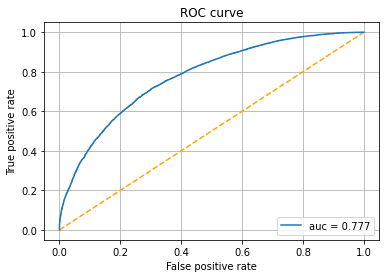

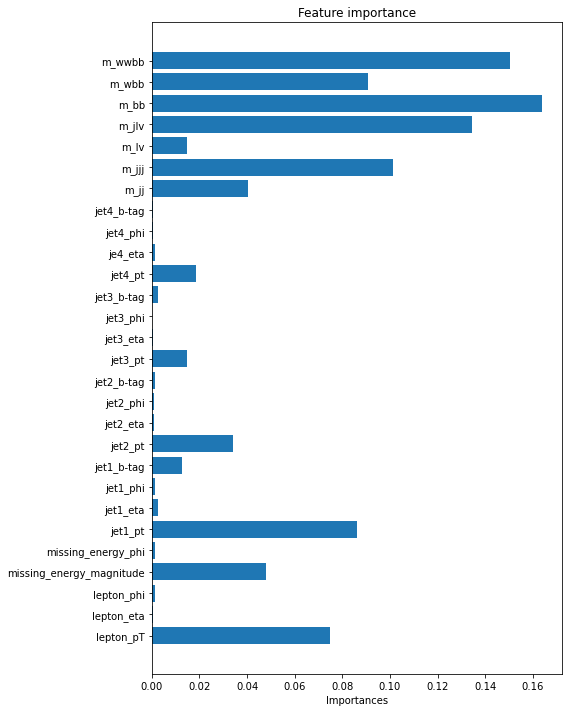

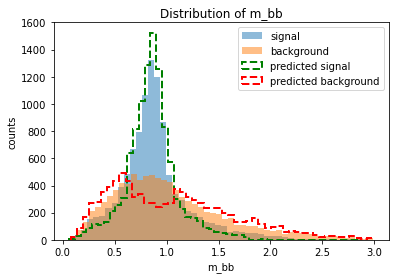

In [17]:
from pyspark.ml.classification import GBTClassifier

inputFile = 'file:///home/jovyan/Higgs100k.parquet'
#inputFile = 'file:///home/jovyan/Higgs1M.parquet'
#inputFile = 'file:///home/jovyan/Higgs10M.parquet'

%time df = spark_session.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)

total_events = df.count()
print('There are '+str(total_events)+' events')

#split the dataset for training and test
train, test = df.randomSplit([0.8,0.2])

# create the input feature vector 
feature = train.columns
feature.remove('label')

from pyspark.ml.feature import VectorAssembler

#VectorAssembler is a transformer that combines a given list of columns into a single vector column
assembler = VectorAssembler(inputCols=feature, outputCol='features')
train = assembler.transform(train)
test = assembler.transform(test)

# slow, 10-20 minutes training time 
#gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=50, maxDepth=10) #slow

# fast, about 1m to train
gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=20, maxDepth=5) 

%time
gbt_model = gbt.fit(train)

# compute AUC on the test set
result = gbt_model.transform(test)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")
print("Test set AUC = " + str(evaluator.evaluate(result)))

#print metrics
printMetrics(evaluator, result)

#make ROC curve
drawROC(result)

#plot features vs importance
drawFeatures(feature, gbt_model)

#plot signal vs background with prediction
plotSignalvsBgWithPrediction(test, result, 'm_bb')

# MCP

CPU times: user 7 µs, sys: 7 µs, total: 14 µs
Wall time: 30.3 µs
Test set AUC = 0.7192440602198051
AUC: 0.719
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 8360|
|  0.0|       1.0| 4425|
|  1.0|       0.0| 2250|
|  0.0|       0.0| 4902|
+-----+----------+-----+

n precision: 0.654
n recall: 0.788
n accuracy: 0.665
n F1 score: 0.715


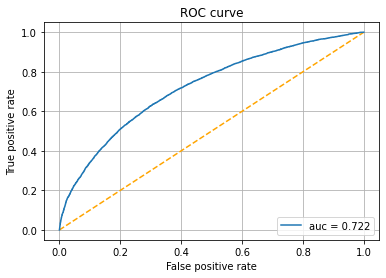

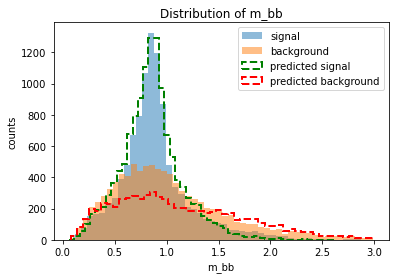

In [18]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

# specify layers for the neural network:

# input layer of size 28 (features), two intermediate of size 30, and output of size 2 (classes)
layers = [28, 30, 30, 2]

# create the trainer and set its parameters
mpc = MultilayerPerceptronClassifier(labelCol='label', featuresCol='features', maxIter=100, layers=layers, blockSize=128, seed=1234)

%time
model_mpc = mpc.fit(train)

# compute accuracy on the test set
from pyspark.ml.evaluation import BinaryClassificationEvaluator

result = model_mpc.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")
print("Test set AUC = " + str(evaluator.evaluate(result)))

#print metrics
printMetrics(evaluator, result)

#make ROC curve
drawROC(result)

#plot signal vs background with prediction
plotSignalvsBgWithPrediction(test, result, 'm_bb')

# Keras

CPU times: user 249 ms, sys: 222 ms, total: 471 ms
Wall time: 144 ms
CPU times: user 42.9 s, sys: 17.6 s, total: 1min
Wall time: 17 s
Precision: 0.6735443989641634
Recall: 0.757658334899455
Accuracy: 0.67565
F1 Score: 0.7131296157077787


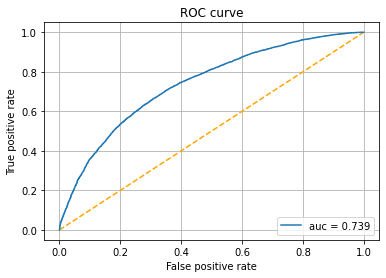

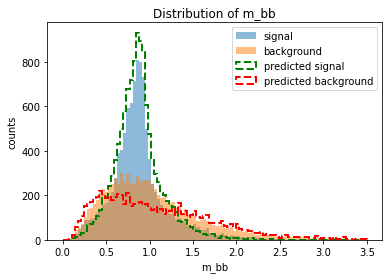

In [19]:
#ignore warnings from Tensorflow
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=DeprecationWarning)
import tensorflow as tf
#if type(tf.contrib) != type(tf): tf.contrib._warning = None
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#import Keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping

inputFile = 'file:///home/jovyan/Higgs100k.parquet'
#inputFile = 'file:///home/jovyan/Higgs1M.parquet'
#inputFile = 'file:///home/jovyan/Higgs10M.parquet'

%time df = pd.read_parquet(inputFile)

# The first column is the target variable
y = df.iloc[:, 0] #df with label
x = df.iloc[: , 1:] #df with all other variables

from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# create the model
import keras
from keras import layers

model = keras.Sequential(
    [
        layers.Dense(100, activation="relu", name="layer", input_shape=(28,)),
        layers.Dense(1, activation="sigmoid", name="output")
    ]
)

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='Accuracy')

# set batch size according to size of the input sample!!!
# start training with reasonable numer of epoch

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

%time history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test), callbacks=[es], verbose=0)

# apply model to get predictions on test set
y_pred = model.predict(x_test)

#print metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

y_model = (y_pred >= 0.5).astype(int)

# Precision, recall, accuracy, F1 score
precision = precision_score(y_test, y_model)
recall = recall_score(y_test, y_model)
accuracy = accuracy_score(y_test, y_model)
f1 = f1_score(y_test, y_model)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

#draw ROC
drawROC2(y_test, y_pred)

#plot signal vs background with prediction
variable = 'm_bb'

# Get the predicted probabilities for the positive class
y_pred_prob = model.predict(x_test)  # Use .ravel() to flatten to a 1D array

plotSignalvsBgWithPrediction2(x_test[variable], y_test, y_pred_prob, variable)

### Accuracy, AUC and feature distributions

- Accuracy:
    - GBT: 0.706
    - Keras: 0.676

- AUC:
    - GBT: 0.777
    - Keras: 0.739

- Others parameters:

    - GBT:
        - Precision: 0.722
        - Recall: 0.728
        - Accuracy: 0.706
        - F1 score: 0.725
    - Keras:
        - Precision: 0.674
        - Recall: 0.758
        - Accuracy: 0.676
        - F1 Score: 0.713

- Signal vs background:\
The two models provide similar signal and background reconstruction for the most important feature.
The performance parameters are similar for the two models. 

- NOTE: The biggest difference is in the precision parameter, which can therefore be considered the most critical; the Keras model performs a better reconstruction of the most important feature but has a lower precision than the GBT model.

### Time

- num_workers=1:
    - GBT: 19.8 µs
    - Keras: 16.3 s

- num_workers=5:
    - GBT:  20 µs
    - Keras: 17 s
    
There is no significant difference in execution time when considering a number of workers of 1 or 5. Probably because short times (order of seconds and µs) are being considered.

In [21]:
# When you're done, stop spark
spark.stop()